# **Ch04.분류 실습 #2**

**Ch04-02. 분류 실습 - 캐글 산탄데르 고객 만족 예측**

* 주제 : 고객 만족 여부 예측 - XGBoost와 LightGBM활용
* 데이터 셋 : Kaggle의 산탄데르 고객 만족 데이터셋 https://www.kaggle.com/c/santander-customer-satisfaction/data
* 특징 : 해당 데이터 셋은 산탄데르 은행이 캐글에 경연을 의뢰한 데이터로서 370개의 피처 이름은 모두 익명 처리돼 이름만을 가지고 어떤 속성인지는 추정 할 수 없음. 클래스 레이블 명은 TARGET이며, 이 값이 1이면 불만을 가진 고객, 0이면 만족한 고객임.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-satisfaction/train.csv
/kaggle/input/santander-customer-satisfaction/test.csv
/kaggle/input/santander-customer-satisfaction/sample_submission.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('/kaggle/input/santander-customer-satisfaction/train.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


익명의 370개 피처 + target 피처 = 371개의 피처

In [4]:
# 피처의 타입과 Null값 확인
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
# 만족과 불만족 비율 확인(Target 속성 값의 분포)
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


## data preprocessing

In [6]:
# 각 피처의 값 분포 확인
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


var3칼럼의 경우 min값이 -999999인데, NaN이나 특정 예외 값을 변환했을 것이다. 이는 다른 값에 비해 너무 편차가 심하므로 가장 값이 많은 2로 변환할 것이다.

In [7]:
# -999999값인 데이터 수 확인
print(cust_df.var3.value_counts()[:10])

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


In [8]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True) # ID는 단순 식별자이므로 피처 드롭

# 피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame의 맨 마지막에 위치하므로 칼럼위치 -1로 분리
X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [9]:
# train, test split
# 비대칭 데이터셋이므로 split 후 Target값 분포도가 비슷하게 추출되었는지 확인
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size = 0.2, random_state = 0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 shape:{0}, 테스트 세트 shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt) # 전체/split 후
print('\n테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt) # 전체/split 후

학습 세트 shape:(60816, 369), 테스트 세트 shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


학습과 테스트 셋 모두 TARGET값의 분포가 원본 데이터와 유사하게 4%정도로 만들어졌다.

## XGBoost 모델 학습과 하이퍼 파라미터 튜닝
1. XGBoost 학습 모델 생성
2. 예측 결과를 ROC AUC로 평가

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
           eval_metric = "auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')

[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82746
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85830	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84054
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.880

In [16]:
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

ROC AUC: 0.8413


**학습 시간이 많이 필요한 ML모델인 경우 하이퍼 파라미터 튜닝 수행 요령**

1. 2~3개 정도의 파라미터를 결합해 최적 파라미터 찾기
2. 최적 파라미터를 기반으로 다시 1~2개 파라미터를 결합해 파라미터 튜닝 수행

In [17]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도 향상을 위해 n_estimators를 100으로 감소 
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7], 'min_child_weight':[1, 3], 'colsample_bytree':[0.5, 0.75]}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric = "auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')

[0]	validation_0-auc:0.71542	validation_1-auc:0.72246
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.81309	validation_1-auc:0.81699
[2]	validation_0-auc:0.80627	validation_1-auc:0.81328
[3]	validation_0-auc:0.81823	validation_1-auc:0.82173
[4]	validation_0-auc:0.82843	validation_1-auc:0.82995
[5]	validation_0-auc:0.82283	validation_1-auc:0.82120
[6]	validation_0-auc:0.82370	validation_1-auc:0.81956
[7]	validation_0-auc:0.83382	validation_1-auc:0.82896
[8]	validation_0-auc:0.84159	validation_1-auc:0.83537
[9]	validation_0-auc:0.84200	validation_1-auc:0.83186
[10]	validation_0-auc:0.84817	validation_1-auc:0.83560
[11]	validation_0-auc:0.85169	validation_1-auc:0.83630
[12]	validation_0-auc:0.85369	validation_1-auc:0.83862
[13]	validation_0-auc:0.85506	validation_1-auc:0.83667
[14]	validation_0-auc:0.85614	validation_1-auc:0.83658
[15]	validation_0-auc:0.8585

[39]	validation_0-auc:0.87427	validation_1-auc:0.84050
[40]	validation_0-auc:0.87499	validation_1-auc:0.84046
[41]	validation_0-auc:0.87512	validation_1-auc:0.84006
[42]	validation_0-auc:0.87600	validation_1-auc:0.84033
[43]	validation_0-auc:0.87630	validation_1-auc:0.83968
[44]	validation_0-auc:0.87663	validation_1-auc:0.83936
[45]	validation_0-auc:0.87681	validation_1-auc:0.83921
[46]	validation_0-auc:0.87726	validation_1-auc:0.83924
[47]	validation_0-auc:0.87749	validation_1-auc:0.83937
Stopping. Best iteration:
[17]	validation_0-auc:0.86280	validation_1-auc:0.84167

[0]	validation_0-auc:0.71401	validation_1-auc:0.72383
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.81504	validation_1-auc:0.81936
[2]	validation_0-auc:0.80795	validation_1-auc:0.81432
[3]	validation_0-auc:0.82074	validation_1-auc:0.82308
[4]	validation_0-auc:0.82988	validation_1-auc:0.83

[25]	validation_0-auc:0.86548	validation_1-auc:0.84276
[26]	validation_0-auc:0.86575	validation_1-auc:0.84272
[27]	validation_0-auc:0.86605	validation_1-auc:0.84331
[28]	validation_0-auc:0.86684	validation_1-auc:0.84370
[29]	validation_0-auc:0.86777	validation_1-auc:0.84351
[30]	validation_0-auc:0.86833	validation_1-auc:0.84339
[31]	validation_0-auc:0.86891	validation_1-auc:0.84334
[32]	validation_0-auc:0.86895	validation_1-auc:0.84345
[33]	validation_0-auc:0.86927	validation_1-auc:0.84332
[34]	validation_0-auc:0.86979	validation_1-auc:0.84354
[35]	validation_0-auc:0.87008	validation_1-auc:0.84338
[36]	validation_0-auc:0.87044	validation_1-auc:0.84337
[37]	validation_0-auc:0.87062	validation_1-auc:0.84328
[38]	validation_0-auc:0.87105	validation_1-auc:0.84294
[39]	validation_0-auc:0.87123	validation_1-auc:0.84308
[40]	validation_0-auc:0.87131	validation_1-auc:0.84326
[41]	validation_0-auc:0.87166	validation_1-auc:0.84345
[42]	validation_0-auc:0.87191	validation_1-auc:0.84406
[43]	valid

[50]	validation_0-auc:0.89953	validation_1-auc:0.83030
[51]	validation_0-auc:0.90042	validation_1-auc:0.83081
[52]	validation_0-auc:0.90046	validation_1-auc:0.83086
Stopping. Best iteration:
[22]	validation_0-auc:0.88582	validation_1-auc:0.83834

[0]	validation_0-auc:0.73684	validation_1-auc:0.73410
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82213	validation_1-auc:0.81430
[2]	validation_0-auc:0.81722	validation_1-auc:0.81004
[3]	validation_0-auc:0.83335	validation_1-auc:0.82519
[4]	validation_0-auc:0.84204	validation_1-auc:0.82935
[5]	validation_0-auc:0.84039	validation_1-auc:0.82427
[6]	validation_0-auc:0.84256	validation_1-auc:0.82006
[7]	validation_0-auc:0.85181	validation_1-auc:0.82655
[8]	validation_0-auc:0.85930	validation_1-auc:0.82984
[9]	validation_0-auc:0.86187	validation_1-auc:0.82570
[10]	validation_0-auc:0.86630	validation_1-auc:0.83177
[

[31]	validation_0-auc:0.88522	validation_1-auc:0.84000
[32]	validation_0-auc:0.88551	validation_1-auc:0.83964
[33]	validation_0-auc:0.88564	validation_1-auc:0.83973
[34]	validation_0-auc:0.88583	validation_1-auc:0.83950
[35]	validation_0-auc:0.88612	validation_1-auc:0.83937
[36]	validation_0-auc:0.88626	validation_1-auc:0.83910
[37]	validation_0-auc:0.88627	validation_1-auc:0.83881
[38]	validation_0-auc:0.88630	validation_1-auc:0.83866
[39]	validation_0-auc:0.88698	validation_1-auc:0.83782
[40]	validation_0-auc:0.88716	validation_1-auc:0.83785
[41]	validation_0-auc:0.88749	validation_1-auc:0.83704
[42]	validation_0-auc:0.88767	validation_1-auc:0.83697
[43]	validation_0-auc:0.88826	validation_1-auc:0.83700
[44]	validation_0-auc:0.88873	validation_1-auc:0.83662
[45]	validation_0-auc:0.88883	validation_1-auc:0.83625
[46]	validation_0-auc:0.88948	validation_1-auc:0.83603
[47]	validation_0-auc:0.89023	validation_1-auc:0.83623
[48]	validation_0-auc:0.89034	validation_1-auc:0.83566
[49]	valid

[21]	validation_0-auc:0.86626	validation_1-auc:0.83867
[22]	validation_0-auc:0.86735	validation_1-auc:0.83852
[23]	validation_0-auc:0.86795	validation_1-auc:0.83935
[24]	validation_0-auc:0.86876	validation_1-auc:0.83916
[25]	validation_0-auc:0.86951	validation_1-auc:0.83874
[26]	validation_0-auc:0.87019	validation_1-auc:0.83994
[27]	validation_0-auc:0.87082	validation_1-auc:0.84027
[28]	validation_0-auc:0.87113	validation_1-auc:0.84016
[29]	validation_0-auc:0.87138	validation_1-auc:0.84032
[30]	validation_0-auc:0.87153	validation_1-auc:0.84063
[31]	validation_0-auc:0.87250	validation_1-auc:0.84072
[32]	validation_0-auc:0.87287	validation_1-auc:0.84029
[33]	validation_0-auc:0.87325	validation_1-auc:0.84054
[34]	validation_0-auc:0.87396	validation_1-auc:0.84021
[35]	validation_0-auc:0.87397	validation_1-auc:0.84020
[36]	validation_0-auc:0.87432	validation_1-auc:0.84017
[37]	validation_0-auc:0.87460	validation_1-auc:0.84003
[38]	validation_0-auc:0.87483	validation_1-auc:0.84007
[39]	valid

[8]	validation_0-auc:0.84727	validation_1-auc:0.83448
[9]	validation_0-auc:0.84909	validation_1-auc:0.83638
[10]	validation_0-auc:0.85035	validation_1-auc:0.83643
[11]	validation_0-auc:0.85280	validation_1-auc:0.83582
[12]	validation_0-auc:0.85500	validation_1-auc:0.83700
[13]	validation_0-auc:0.85697	validation_1-auc:0.83697
[14]	validation_0-auc:0.85801	validation_1-auc:0.83784
[15]	validation_0-auc:0.85914	validation_1-auc:0.83860
[16]	validation_0-auc:0.86007	validation_1-auc:0.83913
[17]	validation_0-auc:0.86106	validation_1-auc:0.83969
[18]	validation_0-auc:0.86165	validation_1-auc:0.83896
[19]	validation_0-auc:0.86269	validation_1-auc:0.83925
[20]	validation_0-auc:0.86325	validation_1-auc:0.83889
[21]	validation_0-auc:0.86485	validation_1-auc:0.83907
[22]	validation_0-auc:0.86548	validation_1-auc:0.83941
[23]	validation_0-auc:0.86585	validation_1-auc:0.83969
[24]	validation_0-auc:0.86685	validation_1-auc:0.83950
[25]	validation_0-auc:0.86778	validation_1-auc:0.83911
[26]	validat

[36]	validation_0-auc:0.89091	validation_1-auc:0.83357
[37]	validation_0-auc:0.89106	validation_1-auc:0.83288
[38]	validation_0-auc:0.89128	validation_1-auc:0.83243
[39]	validation_0-auc:0.89117	validation_1-auc:0.83242
[40]	validation_0-auc:0.89237	validation_1-auc:0.83213
Stopping. Best iteration:
[10]	validation_0-auc:0.86435	validation_1-auc:0.83700

[0]	validation_0-auc:0.81401	validation_1-auc:0.80440
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82848	validation_1-auc:0.82108
[2]	validation_0-auc:0.83397	validation_1-auc:0.82307
[3]	validation_0-auc:0.84318	validation_1-auc:0.82830
[4]	validation_0-auc:0.84662	validation_1-auc:0.83173
[5]	validation_0-auc:0.85412	validation_1-auc:0.83224
[6]	validation_0-auc:0.85810	validation_1-auc:0.83372
[7]	validation_0-auc:0.86087	validation_1-auc:0.83494
[8]	validation_0-auc:0.86321	validation_1-auc:0.83623


[31]	validation_0-auc:0.88241	validation_1-auc:0.82996
[32]	validation_0-auc:0.88300	validation_1-auc:0.83005
[33]	validation_0-auc:0.88365	validation_1-auc:0.82994
[34]	validation_0-auc:0.88438	validation_1-auc:0.82919
[35]	validation_0-auc:0.88504	validation_1-auc:0.82929
[36]	validation_0-auc:0.88563	validation_1-auc:0.83028
[37]	validation_0-auc:0.88623	validation_1-auc:0.83036
[38]	validation_0-auc:0.88659	validation_1-auc:0.83025
[39]	validation_0-auc:0.88762	validation_1-auc:0.83034
[40]	validation_0-auc:0.88836	validation_1-auc:0.83052
[41]	validation_0-auc:0.88934	validation_1-auc:0.82940
[42]	validation_0-auc:0.88931	validation_1-auc:0.82912
Stopping. Best iteration:
[12]	validation_0-auc:0.86800	validation_1-auc:0.83594

[0]	validation_0-auc:0.81479	validation_1-auc:0.81277
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.83031	validation_1-auc:0

[28]	validation_0-auc:0.89916	validation_1-auc:0.83840
[29]	validation_0-auc:0.89946	validation_1-auc:0.83818
[30]	validation_0-auc:0.89980	validation_1-auc:0.83798
[31]	validation_0-auc:0.90095	validation_1-auc:0.83849
[32]	validation_0-auc:0.90162	validation_1-auc:0.83780
[33]	validation_0-auc:0.90191	validation_1-auc:0.83768
[34]	validation_0-auc:0.90305	validation_1-auc:0.83747
[35]	validation_0-auc:0.90327	validation_1-auc:0.83717
[36]	validation_0-auc:0.90398	validation_1-auc:0.83656
[37]	validation_0-auc:0.90463	validation_1-auc:0.83687
[38]	validation_0-auc:0.90477	validation_1-auc:0.83701
[39]	validation_0-auc:0.90495	validation_1-auc:0.83721
[40]	validation_0-auc:0.90645	validation_1-auc:0.83752
[41]	validation_0-auc:0.90745	validation_1-auc:0.83713
[42]	validation_0-auc:0.90795	validation_1-auc:0.83633
[43]	validation_0-auc:0.90855	validation_1-auc:0.83559
[44]	validation_0-auc:0.90974	validation_1-auc:0.83584
[45]	validation_0-auc:0.90990	validation_1-auc:0.83598
[46]	valid

In [18]:
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

GridSearchCV 최적 파라미터: {'colsample_bytree': 0.75, 'max_depth': 7, 'min_child_weight': 3}
ROC AUC: 0.8418


하이퍼 파라미터 적용 후 ROC AUC가 0.8414->0.8418로 조금 개선되었다. 이제 다시 최적화를 진행해보겠다.
1. 위의 최적 파라미터로 설정
2. n_estimators=1000으로 증가
3. learning_rate는 0.02로 감소
4. reg_alpha=0.03추가

In [19]:
# 위의 2,3,4 진행
xgb_clf = XGBClassifier(n_estimators=100, random_state=156, learning_rate=0.02, max_depth=7, 
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정 후 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,
           eval_metric = "auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82311	validation_1-auc:0.81523
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.82709	validation_1-auc:0.81657
[2]	validation_0-auc:0.83203	validation_1-auc:0.82039
[3]	validation_0-auc:0.83587	validation_1-auc:0.82502
[4]	validation_0-auc:0.83820	validation_1-auc:0.82608
[5]	validation_0-auc:0.83795	validation_1-auc:0.82728
[6]	validation_0-auc:0.83810	validation_1-auc:0.82689
[7]	validation_0-auc:0.83847	validation_1-auc:0.82713
[8]	validation_0-auc:0.83978	validation_1-auc:0.82820
[9]	validation_0-auc:0.83981	validation_1-auc:0.82783
[10]	validation_0-auc:0.84166	validation_1-auc:0.82900
[11]	validation_0-auc:0.84107	validation_1-auc:0.82802
[12]	validation_0-auc:0.84117	validation_1-auc:0.82852
[13]	validation_0-auc:0.84145	validation_1-auc:0.82832
[14]	validation_0-auc:0.84531	validation_1-auc:0.83410
[15]	validation_0-auc:0.844

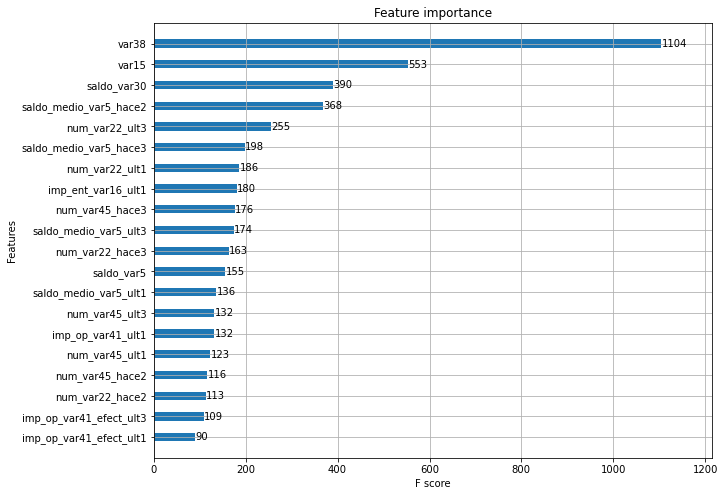

In [21]:
# 튜닝된 모델의 각 피처 중요도 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

## LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [22]:
from lightgbm import LGBMClassifier

# n_estimators는 500으로 설정
lgbm_clf = LGBMClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100,
           eval_metric = "auc", eval_set=[(X_test, y_test)], verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.141

[131]	valid_0's auc: 0.836033	valid_0's binary_logloss: 0.140835
[132]	valid_0's auc: 0.836014	valid_0's binary_logloss: 0.140852
[133]	valid_0's auc: 0.835977	valid_0's binary_logloss: 0.1409
[134]	valid_0's auc: 0.835695	valid_0's binary_logloss: 0.140951
[135]	valid_0's auc: 0.835689	valid_0's binary_logloss: 0.140975
[136]	valid_0's auc: 0.83554	valid_0's binary_logloss: 0.141011
[137]	valid_0's auc: 0.835146	valid_0's binary_logloss: 0.141098
[138]	valid_0's auc: 0.83503	valid_0's binary_logloss: 0.141136
[139]	valid_0's auc: 0.834826	valid_0's binary_logloss: 0.141206
[140]	valid_0's auc: 0.834576	valid_0's binary_logloss: 0.141267
[141]	valid_0's auc: 0.834265	valid_0's binary_logloss: 0.141328
[142]	valid_0's auc: 0.8342	valid_0's binary_logloss: 0.141359
Early stopping, best iteration is:
[42]	valid_0's auc: 0.839599	valid_0's binary_logloss: 0.139408
ROC AUC: 0.8396


In [23]:
# GridSearchCV로 좀 더 다양한 하이퍼 파라미터 튜닝 수행
# 튜닝 대상은 num_leaves, max_depth, min_child_samples, subsample

from sklearn.model_selection import GridSearchCV

# 수행 속도 향상을 위해 n_estimators는 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32, 64],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric = "auc", eval_set=[(X_train, y_train), (X_test, y_test)])

lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832192	valid_0's binary_logloss: 0.147167	valid_1's auc: 0.827305	valid_1's binary_logloss: 0.156391
[4]	valid_0's auc: 0.837507	valid_0's binary_logloss: 0.144132	valid_1's auc: 0.8334	valid_1's binary_logloss: 0.15332
[5]	valid_0's auc: 0.842275	valid_0's binary_logloss: 0.141652	valid_1's auc: 0.836036	valid_1's binary_logloss: 0.150954
[6]	valid_0's auc: 0.844971	valid_0's binary_logloss: 0.139662	valid_1's auc: 0.838026	valid_1's binary_logloss: 0.149041
[7]	valid_0's auc: 0.846612	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.147504
[8]	valid_0's auc: 0.848539	valid_0's binary_logloss: 0.136579	valid_1's auc: 0.839506	va

[28]	valid_0's auc: 0.873243	valid_0's binary_logloss: 0.124448	valid_1's auc: 0.837467	valid_1's binary_logloss: 0.139828
[29]	valid_0's auc: 0.873959	valid_0's binary_logloss: 0.124164	valid_1's auc: 0.83751	valid_1's binary_logloss: 0.139781
[30]	valid_0's auc: 0.874666	valid_0's binary_logloss: 0.123934	valid_1's auc: 0.837891	valid_1's binary_logloss: 0.139667
[31]	valid_0's auc: 0.875615	valid_0's binary_logloss: 0.123703	valid_1's auc: 0.83861	valid_1's binary_logloss: 0.139545
[32]	valid_0's auc: 0.876151	valid_0's binary_logloss: 0.123475	valid_1's auc: 0.838762	valid_1's binary_logloss: 0.13945
[33]	valid_0's auc: 0.877026	valid_0's binary_logloss: 0.123248	valid_1's auc: 0.838799	valid_1's binary_logloss: 0.139439
[34]	valid_0's auc: 0.877606	valid_0's binary_logloss: 0.123057	valid_1's auc: 0.838511	valid_1's binary_logloss: 0.139447
[35]	valid_0's auc: 0.878266	valid_0's binary_logloss: 0.122861	valid_1's auc: 0.838604	valid_1's binary_logloss: 0.139413
[36]	valid_0's auc:

[28]	valid_0's auc: 0.872255	valid_0's binary_logloss: 0.124955	valid_1's auc: 0.838733	valid_1's binary_logloss: 0.139614
[29]	valid_0's auc: 0.872979	valid_0's binary_logloss: 0.124683	valid_1's auc: 0.838445	valid_1's binary_logloss: 0.139634
[30]	valid_0's auc: 0.873557	valid_0's binary_logloss: 0.12443	valid_1's auc: 0.838392	valid_1's binary_logloss: 0.139581
[31]	valid_0's auc: 0.874202	valid_0's binary_logloss: 0.124188	valid_1's auc: 0.837993	valid_1's binary_logloss: 0.139633
[32]	valid_0's auc: 0.874831	valid_0's binary_logloss: 0.123929	valid_1's auc: 0.837759	valid_1's binary_logloss: 0.139651
[33]	valid_0's auc: 0.87536	valid_0's binary_logloss: 0.123718	valid_1's auc: 0.838121	valid_1's binary_logloss: 0.139601
[34]	valid_0's auc: 0.876098	valid_0's binary_logloss: 0.123446	valid_1's auc: 0.838127	valid_1's binary_logloss: 0.13959
[35]	valid_0's auc: 0.876685	valid_0's binary_logloss: 0.123227	valid_1's auc: 0.837767	valid_1's binary_logloss: 0.139632
[36]	valid_0's auc:

[1]	valid_0's auc: 0.814371	valid_0's binary_logloss: 0.156452	valid_1's auc: 0.813175	valid_1's binary_logloss: 0.165418
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.827202	valid_0's binary_logloss: 0.151081	valid_1's auc: 0.819989	valid_1's binary_logloss: 0.160086
[3]	valid_0's auc: 0.836893	valid_0's binary_logloss: 0.147219	valid_1's auc: 0.828833	valid_1's binary_logloss: 0.156403
[4]	valid_0's auc: 0.841451	valid_0's binary_logloss: 0.144211	valid_1's auc: 0.830881	valid_1's binary_logloss: 0.153547
[5]	valid_0's auc: 0.843957	valid_0's binary_logloss: 0.141696	valid_1's auc: 0.832819	valid_1's binary_logloss: 0.151227
[6]	valid_0's auc: 0.847748	valid_0's binary_logloss: 0.139678	valid_1's auc: 0.836614	valid_1's binary_logloss: 0.149329
[7]	valid_0's auc: 0.849327	valid_0's binary_logloss: 0.137985	valid_1's auc: 0.836739	valid_1's binary_logloss: 0.147839
[8]	valid_0's auc: 0.850907	valid_0's binary_logloss: 0.136536	valid_1's auc: 0.83671

[69]	valid_0's auc: 0.892333	valid_0's binary_logloss: 0.116905	valid_1's auc: 0.837619	valid_1's binary_logloss: 0.140006
[70]	valid_0's auc: 0.892833	valid_0's binary_logloss: 0.116695	valid_1's auc: 0.837858	valid_1's binary_logloss: 0.139965
[71]	valid_0's auc: 0.892846	valid_0's binary_logloss: 0.116607	valid_1's auc: 0.837642	valid_1's binary_logloss: 0.140063
[72]	valid_0's auc: 0.892948	valid_0's binary_logloss: 0.116525	valid_1's auc: 0.837423	valid_1's binary_logloss: 0.140129
Early stopping, best iteration is:
[42]	valid_0's auc: 0.882841	valid_0's binary_logloss: 0.121168	valid_1's auc: 0.83955	valid_1's binary_logloss: 0.139266
[1]	valid_0's auc: 0.821645	valid_0's binary_logloss: 0.156528	valid_1's auc: 0.81857	valid_1's binary_logloss: 0.165101
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.827652	valid_0's binary_logloss: 0.151187	valid_1's auc: 0.82254	valid_1's binary_logloss: 0.160088
[3]	valid_0's auc: 0.836059	valid_0's binary_log

[9]	valid_0's auc: 0.863502	valid_0's binary_logloss: 0.132674	valid_1's auc: 0.83389	valid_1's binary_logloss: 0.145855
[10]	valid_0's auc: 0.865388	valid_0's binary_logloss: 0.131436	valid_1's auc: 0.83527	valid_1's binary_logloss: 0.145006
[11]	valid_0's auc: 0.867991	valid_0's binary_logloss: 0.130246	valid_1's auc: 0.834165	valid_1's binary_logloss: 0.14443
[12]	valid_0's auc: 0.868905	valid_0's binary_logloss: 0.129245	valid_1's auc: 0.834913	valid_1's binary_logloss: 0.143794
[13]	valid_0's auc: 0.871383	valid_0's binary_logloss: 0.128279	valid_1's auc: 0.835098	valid_1's binary_logloss: 0.143188
[14]	valid_0's auc: 0.872929	valid_0's binary_logloss: 0.127403	valid_1's auc: 0.833943	valid_1's binary_logloss: 0.142967
[15]	valid_0's auc: 0.87404	valid_0's binary_logloss: 0.126607	valid_1's auc: 0.833167	valid_1's binary_logloss: 0.142812
[16]	valid_0's auc: 0.875242	valid_0's binary_logloss: 0.12587	valid_1's auc: 0.832607	valid_1's binary_logloss: 0.142587
[17]	valid_0's auc: 0.

[36]	valid_0's auc: 0.896761	valid_0's binary_logloss: 0.115738	valid_1's auc: 0.833866	valid_1's binary_logloss: 0.140566
[37]	valid_0's auc: 0.897255	valid_0's binary_logloss: 0.115445	valid_1's auc: 0.833835	valid_1's binary_logloss: 0.140618
[38]	valid_0's auc: 0.897979	valid_0's binary_logloss: 0.115107	valid_1's auc: 0.833409	valid_1's binary_logloss: 0.14069
[39]	valid_0's auc: 0.898947	valid_0's binary_logloss: 0.114705	valid_1's auc: 0.833262	valid_1's binary_logloss: 0.140754
[40]	valid_0's auc: 0.899579	valid_0's binary_logloss: 0.114409	valid_1's auc: 0.833304	valid_1's binary_logloss: 0.140759
[41]	valid_0's auc: 0.900418	valid_0's binary_logloss: 0.114104	valid_1's auc: 0.833244	valid_1's binary_logloss: 0.140854
[42]	valid_0's auc: 0.901143	valid_0's binary_logloss: 0.113727	valid_1's auc: 0.83271	valid_1's binary_logloss: 0.14096
[43]	valid_0's auc: 0.901603	valid_0's binary_logloss: 0.113493	valid_1's auc: 0.832882	valid_1's binary_logloss: 0.141012
Early stopping, bes

[16]	valid_0's auc: 0.875242	valid_0's binary_logloss: 0.12587	valid_1's auc: 0.832607	valid_1's binary_logloss: 0.142587
[17]	valid_0's auc: 0.876378	valid_0's binary_logloss: 0.125177	valid_1's auc: 0.83187	valid_1's binary_logloss: 0.142458
[18]	valid_0's auc: 0.877407	valid_0's binary_logloss: 0.124483	valid_1's auc: 0.83163	valid_1's binary_logloss: 0.142321
[19]	valid_0's auc: 0.878701	valid_0's binary_logloss: 0.123852	valid_1's auc: 0.831198	valid_1's binary_logloss: 0.142189
[20]	valid_0's auc: 0.880271	valid_0's binary_logloss: 0.123249	valid_1's auc: 0.830575	valid_1's binary_logloss: 0.142161
[21]	valid_0's auc: 0.881003	valid_0's binary_logloss: 0.122681	valid_1's auc: 0.830093	valid_1's binary_logloss: 0.142018
[22]	valid_0's auc: 0.882219	valid_0's binary_logloss: 0.122144	valid_1's auc: 0.829706	valid_1's binary_logloss: 0.141898
[23]	valid_0's auc: 0.883017	valid_0's binary_logloss: 0.121633	valid_1's auc: 0.829552	valid_1's binary_logloss: 0.14183
[24]	valid_0's auc: 

[1]	valid_0's auc: 0.830643	valid_0's binary_logloss: 0.155759	valid_1's auc: 0.816734	valid_1's binary_logloss: 0.164985
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.839231	valid_0's binary_logloss: 0.149985	valid_1's auc: 0.822161	valid_1's binary_logloss: 0.159847
[3]	valid_0's auc: 0.847482	valid_0's binary_logloss: 0.14584	valid_1's auc: 0.828931	valid_1's binary_logloss: 0.156209
[4]	valid_0's auc: 0.85096	valid_0's binary_logloss: 0.142477	valid_1's auc: 0.83076	valid_1's binary_logloss: 0.153261
[5]	valid_0's auc: 0.854424	valid_0's binary_logloss: 0.139743	valid_1's auc: 0.832373	valid_1's binary_logloss: 0.150964
[6]	valid_0's auc: 0.856208	valid_0's binary_logloss: 0.137578	valid_1's auc: 0.835151	valid_1's binary_logloss: 0.149014
[7]	valid_0's auc: 0.857684	valid_0's binary_logloss: 0.135714	valid_1's auc: 0.836459	valid_1's binary_logloss: 0.147459
[8]	valid_0's auc: 0.859848	valid_0's binary_logloss: 0.134043	valid_1's auc: 0.835502	v

[27]	valid_0's auc: 0.868358	valid_0's binary_logloss: 0.126275	valid_1's auc: 0.833055	valid_1's binary_logloss: 0.140387
[28]	valid_0's auc: 0.869148	valid_0's binary_logloss: 0.125976	valid_1's auc: 0.832858	valid_1's binary_logloss: 0.140345
[29]	valid_0's auc: 0.869606	valid_0's binary_logloss: 0.125736	valid_1's auc: 0.832855	valid_1's binary_logloss: 0.140309
[30]	valid_0's auc: 0.870141	valid_0's binary_logloss: 0.125482	valid_1's auc: 0.83291	valid_1's binary_logloss: 0.140261
[31]	valid_0's auc: 0.871526	valid_0's binary_logloss: 0.125141	valid_1's auc: 0.833609	valid_1's binary_logloss: 0.140128
[32]	valid_0's auc: 0.871929	valid_0's binary_logloss: 0.124941	valid_1's auc: 0.833536	valid_1's binary_logloss: 0.14009
[33]	valid_0's auc: 0.872798	valid_0's binary_logloss: 0.124718	valid_1's auc: 0.833168	valid_1's binary_logloss: 0.140121
[34]	valid_0's auc: 0.873431	valid_0's binary_logloss: 0.12451	valid_1's auc: 0.833313	valid_1's binary_logloss: 0.140097
[35]	valid_0's auc:

[13]	valid_0's auc: 0.856458	valid_0's binary_logloss: 0.132288	valid_1's auc: 0.836525	valid_1's binary_logloss: 0.143031
[14]	valid_0's auc: 0.857578	valid_0's binary_logloss: 0.131588	valid_1's auc: 0.836371	valid_1's binary_logloss: 0.142638
[15]	valid_0's auc: 0.858803	valid_0's binary_logloss: 0.130965	valid_1's auc: 0.836382	valid_1's binary_logloss: 0.142207
[16]	valid_0's auc: 0.859796	valid_0's binary_logloss: 0.13041	valid_1's auc: 0.836831	valid_1's binary_logloss: 0.141782
[17]	valid_0's auc: 0.860226	valid_0's binary_logloss: 0.129932	valid_1's auc: 0.837028	valid_1's binary_logloss: 0.141442
[18]	valid_0's auc: 0.861152	valid_0's binary_logloss: 0.129486	valid_1's auc: 0.837531	valid_1's binary_logloss: 0.141159
[19]	valid_0's auc: 0.862227	valid_0's binary_logloss: 0.129003	valid_1's auc: 0.837295	valid_1's binary_logloss: 0.140963
[20]	valid_0's auc: 0.863276	valid_0's binary_logloss: 0.12855	valid_1's auc: 0.837772	valid_1's binary_logloss: 0.140751
[21]	valid_0's auc

[86]	valid_0's auc: 0.891255	valid_0's binary_logloss: 0.116424	valid_1's auc: 0.837141	valid_1's binary_logloss: 0.140382
Early stopping, best iteration is:
[56]	valid_0's auc: 0.885034	valid_0's binary_logloss: 0.120016	valid_1's auc: 0.838201	valid_1's binary_logloss: 0.139564
[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.82918	valid_0's binary_logloss: 0.151167	valid_1's auc: 0.823351	valid_1's binary_logloss: 0.160065
[3]	valid_0's auc: 0.836091	valid_0's binary_logloss: 0.147411	valid_1's auc: 0.828685	valid_1's binary_logloss: 0.156507
[4]	valid_0's auc: 0.840405	valid_0's binary_logloss: 0.144503	valid_1's auc: 0.833022	valid_1's binary_logloss: 0.15358
[5]	valid_0's auc: 0.843736	valid_0's binary_logloss: 0.142035	valid_1's auc: 0.835479	valid_1's binary_logloss: 0.151317
[6]	valid_0's auc: 0.844764	valid_0's binary_loglo

[28]	valid_0's auc: 0.870113	valid_0's binary_logloss: 0.125557	valid_1's auc: 0.839245	valid_1's binary_logloss: 0.139366
[29]	valid_0's auc: 0.870833	valid_0's binary_logloss: 0.125297	valid_1's auc: 0.839149	valid_1's binary_logloss: 0.139358
[30]	valid_0's auc: 0.871919	valid_0's binary_logloss: 0.125018	valid_1's auc: 0.838964	valid_1's binary_logloss: 0.139376
[31]	valid_0's auc: 0.872636	valid_0's binary_logloss: 0.12476	valid_1's auc: 0.838793	valid_1's binary_logloss: 0.139326
[32]	valid_0's auc: 0.87325	valid_0's binary_logloss: 0.124553	valid_1's auc: 0.83903	valid_1's binary_logloss: 0.13928
[33]	valid_0's auc: 0.87392	valid_0's binary_logloss: 0.124351	valid_1's auc: 0.838933	valid_1's binary_logloss: 0.13927
[34]	valid_0's auc: 0.874695	valid_0's binary_logloss: 0.124137	valid_1's auc: 0.839081	valid_1's binary_logloss: 0.13921
[35]	valid_0's auc: 0.875082	valid_0's binary_logloss: 0.123965	valid_1's auc: 0.839016	valid_1's binary_logloss: 0.139215
[36]	valid_0's auc: 0.8

[58]	valid_0's auc: 0.885429	valid_0's binary_logloss: 0.119733	valid_1's auc: 0.838352	valid_1's binary_logloss: 0.139566
[59]	valid_0's auc: 0.885751	valid_0's binary_logloss: 0.119583	valid_1's auc: 0.838177	valid_1's binary_logloss: 0.139641
[60]	valid_0's auc: 0.885952	valid_0's binary_logloss: 0.119461	valid_1's auc: 0.838373	valid_1's binary_logloss: 0.139615
[61]	valid_0's auc: 0.886123	valid_0's binary_logloss: 0.119357	valid_1's auc: 0.838135	valid_1's binary_logloss: 0.139644
[62]	valid_0's auc: 0.886592	valid_0's binary_logloss: 0.119218	valid_1's auc: 0.83826	valid_1's binary_logloss: 0.139648
[63]	valid_0's auc: 0.886712	valid_0's binary_logloss: 0.11911	valid_1's auc: 0.838084	valid_1's binary_logloss: 0.139729
[64]	valid_0's auc: 0.886807	valid_0's binary_logloss: 0.119003	valid_1's auc: 0.838391	valid_1's binary_logloss: 0.139706
[65]	valid_0's auc: 0.887021	valid_0's binary_logloss: 0.11888	valid_1's auc: 0.838343	valid_1's binary_logloss: 0.13972
[66]	valid_0's auc: 

[39]	valid_0's auc: 0.892363	valid_0's binary_logloss: 0.117294	valid_1's auc: 0.828552	valid_1's binary_logloss: 0.141556
[40]	valid_0's auc: 0.89279	valid_0's binary_logloss: 0.117026	valid_1's auc: 0.828434	valid_1's binary_logloss: 0.141604
[41]	valid_0's auc: 0.893455	valid_0's binary_logloss: 0.116765	valid_1's auc: 0.828598	valid_1's binary_logloss: 0.141573
[42]	valid_0's auc: 0.893797	valid_0's binary_logloss: 0.116515	valid_1's auc: 0.828463	valid_1's binary_logloss: 0.1416
Early stopping, best iteration is:
[12]	valid_0's auc: 0.86681	valid_0's binary_logloss: 0.130312	valid_1's auc: 0.835596	valid_1's binary_logloss: 0.143395
[1]	valid_0's auc: 0.830474	valid_0's binary_logloss: 0.155928	valid_1's auc: 0.817343	valid_1's binary_logloss: 0.164928
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.842991	valid_0's binary_logloss: 0.150276	valid_1's auc: 0.827907	valid_1's binary_logloss: 0.159411
[3]	valid_0's auc: 0.851825	valid_0's binary_logl

[24]	valid_0's auc: 0.882711	valid_0's binary_logloss: 0.122314	valid_1's auc: 0.83633	valid_1's binary_logloss: 0.140219
[25]	valid_0's auc: 0.883523	valid_0's binary_logloss: 0.121852	valid_1's auc: 0.836558	valid_1's binary_logloss: 0.140159
[26]	valid_0's auc: 0.88437	valid_0's binary_logloss: 0.121425	valid_1's auc: 0.83683	valid_1's binary_logloss: 0.140016
[27]	valid_0's auc: 0.885636	valid_0's binary_logloss: 0.120914	valid_1's auc: 0.836819	valid_1's binary_logloss: 0.13996
[28]	valid_0's auc: 0.886325	valid_0's binary_logloss: 0.120555	valid_1's auc: 0.837376	valid_1's binary_logloss: 0.139864
[29]	valid_0's auc: 0.887055	valid_0's binary_logloss: 0.120163	valid_1's auc: 0.836929	valid_1's binary_logloss: 0.139938
[30]	valid_0's auc: 0.887923	valid_0's binary_logloss: 0.119761	valid_1's auc: 0.836813	valid_1's binary_logloss: 0.13991
[31]	valid_0's auc: 0.888783	valid_0's binary_logloss: 0.11938	valid_1's auc: 0.836207	valid_1's binary_logloss: 0.139954
[32]	valid_0's auc: 0.

[34]	valid_0's auc: 0.888706	valid_0's binary_logloss: 0.118927	valid_1's auc: 0.829105	valid_1's binary_logloss: 0.141416
[35]	valid_0's auc: 0.889307	valid_0's binary_logloss: 0.118593	valid_1's auc: 0.828734	valid_1's binary_logloss: 0.141513
[36]	valid_0's auc: 0.890033	valid_0's binary_logloss: 0.11827	valid_1's auc: 0.829267	valid_1's binary_logloss: 0.141387
[37]	valid_0's auc: 0.890794	valid_0's binary_logloss: 0.11791	valid_1's auc: 0.829028	valid_1's binary_logloss: 0.141414
[38]	valid_0's auc: 0.891883	valid_0's binary_logloss: 0.11759	valid_1's auc: 0.828809	valid_1's binary_logloss: 0.141499
[39]	valid_0's auc: 0.892363	valid_0's binary_logloss: 0.117294	valid_1's auc: 0.828552	valid_1's binary_logloss: 0.141556
[40]	valid_0's auc: 0.89279	valid_0's binary_logloss: 0.117026	valid_1's auc: 0.828434	valid_1's binary_logloss: 0.141604
[41]	valid_0's auc: 0.893455	valid_0's binary_logloss: 0.116765	valid_1's auc: 0.828598	valid_1's binary_logloss: 0.141573
[42]	valid_0's auc: 

[17]	valid_0's auc: 0.874492	valid_0's binary_logloss: 0.126262	valid_1's auc: 0.836201	valid_1's binary_logloss: 0.141126
[18]	valid_0's auc: 0.87595	valid_0's binary_logloss: 0.125627	valid_1's auc: 0.83635	valid_1's binary_logloss: 0.140886
[19]	valid_0's auc: 0.877131	valid_0's binary_logloss: 0.125013	valid_1's auc: 0.836076	valid_1's binary_logloss: 0.140739
[20]	valid_0's auc: 0.878085	valid_0's binary_logloss: 0.124466	valid_1's auc: 0.83617	valid_1's binary_logloss: 0.140566
[21]	valid_0's auc: 0.879486	valid_0's binary_logloss: 0.123852	valid_1's auc: 0.836204	valid_1's binary_logloss: 0.140435
[22]	valid_0's auc: 0.880587	valid_0's binary_logloss: 0.123297	valid_1's auc: 0.836447	valid_1's binary_logloss: 0.140314
[23]	valid_0's auc: 0.881726	valid_0's binary_logloss: 0.122794	valid_1's auc: 0.836098	valid_1's binary_logloss: 0.140303
[24]	valid_0's auc: 0.882711	valid_0's binary_logloss: 0.122314	valid_1's auc: 0.83633	valid_1's binary_logloss: 0.140219
[25]	valid_0's auc: 

[27]	valid_0's auc: 0.871105	valid_0's binary_logloss: 0.125306	valid_1's auc: 0.834075	valid_1's binary_logloss: 0.140221
[28]	valid_0's auc: 0.871842	valid_0's binary_logloss: 0.125006	valid_1's auc: 0.833809	valid_1's binary_logloss: 0.140204
[29]	valid_0's auc: 0.872834	valid_0's binary_logloss: 0.124667	valid_1's auc: 0.833672	valid_1's binary_logloss: 0.140234
[30]	valid_0's auc: 0.873209	valid_0's binary_logloss: 0.124428	valid_1's auc: 0.833228	valid_1's binary_logloss: 0.140246
[31]	valid_0's auc: 0.873779	valid_0's binary_logloss: 0.124154	valid_1's auc: 0.833437	valid_1's binary_logloss: 0.140196
[32]	valid_0's auc: 0.875169	valid_0's binary_logloss: 0.123793	valid_1's auc: 0.833543	valid_1's binary_logloss: 0.140131
[33]	valid_0's auc: 0.875945	valid_0's binary_logloss: 0.123538	valid_1's auc: 0.833771	valid_1's binary_logloss: 0.140074
[34]	valid_0's auc: 0.876838	valid_0's binary_logloss: 0.123273	valid_1's auc: 0.834188	valid_1's binary_logloss: 0.140029
[35]	valid_0's a

[61]	valid_0's auc: 0.890299	valid_0's binary_logloss: 0.117943	valid_1's auc: 0.838077	valid_1's binary_logloss: 0.139821
[62]	valid_0's auc: 0.890524	valid_0's binary_logloss: 0.117814	valid_1's auc: 0.838161	valid_1's binary_logloss: 0.139809
[63]	valid_0's auc: 0.890741	valid_0's binary_logloss: 0.117695	valid_1's auc: 0.837883	valid_1's binary_logloss: 0.139891
[64]	valid_0's auc: 0.891078	valid_0's binary_logloss: 0.117563	valid_1's auc: 0.837654	valid_1's binary_logloss: 0.139952
[65]	valid_0's auc: 0.891298	valid_0's binary_logloss: 0.117396	valid_1's auc: 0.837908	valid_1's binary_logloss: 0.139936
[66]	valid_0's auc: 0.891444	valid_0's binary_logloss: 0.117294	valid_1's auc: 0.837798	valid_1's binary_logloss: 0.139968
[67]	valid_0's auc: 0.891558	valid_0's binary_logloss: 0.117199	valid_1's auc: 0.837884	valid_1's binary_logloss: 0.139951
[68]	valid_0's auc: 0.891842	valid_0's binary_logloss: 0.117047	valid_1's auc: 0.837726	valid_1's binary_logloss: 0.139964
[69]	valid_0's a

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832192	valid_0's binary_logloss: 0.147167	valid_1's auc: 0.827305	valid_1's binary_logloss: 0.156391
[4]	valid_0's auc: 0.837507	valid_0's binary_logloss: 0.144132	valid_1's auc: 0.8334	valid_1's binary_logloss: 0.15332
[5]	valid_0's auc: 0.842275	valid_0's binary_logloss: 0.141652	valid_1's auc: 0.836036	valid_1's binary_logloss: 0.150954
[6]	valid_0's auc: 0.844971	valid_0's binary_logloss: 0.139662	valid_1's auc: 0.838026	valid_1's binary_logloss: 0.149041
[7]	valid_0's auc: 0.846612	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.147504
[8]	valid_0's auc: 0.848539	valid_0's binary_logloss: 0.136579	valid_1's auc: 0.839506	va

[28]	valid_0's auc: 0.873243	valid_0's binary_logloss: 0.124448	valid_1's auc: 0.837467	valid_1's binary_logloss: 0.139828
[29]	valid_0's auc: 0.873959	valid_0's binary_logloss: 0.124164	valid_1's auc: 0.83751	valid_1's binary_logloss: 0.139781
[30]	valid_0's auc: 0.874666	valid_0's binary_logloss: 0.123934	valid_1's auc: 0.837891	valid_1's binary_logloss: 0.139667
[31]	valid_0's auc: 0.875615	valid_0's binary_logloss: 0.123703	valid_1's auc: 0.83861	valid_1's binary_logloss: 0.139545
[32]	valid_0's auc: 0.876151	valid_0's binary_logloss: 0.123475	valid_1's auc: 0.838762	valid_1's binary_logloss: 0.13945
[33]	valid_0's auc: 0.877026	valid_0's binary_logloss: 0.123248	valid_1's auc: 0.838799	valid_1's binary_logloss: 0.139439
[34]	valid_0's auc: 0.877606	valid_0's binary_logloss: 0.123057	valid_1's auc: 0.838511	valid_1's binary_logloss: 0.139447
[35]	valid_0's auc: 0.878266	valid_0's binary_logloss: 0.122861	valid_1's auc: 0.838604	valid_1's binary_logloss: 0.139413
[36]	valid_0's auc:

[28]	valid_0's auc: 0.872255	valid_0's binary_logloss: 0.124955	valid_1's auc: 0.838733	valid_1's binary_logloss: 0.139614
[29]	valid_0's auc: 0.872979	valid_0's binary_logloss: 0.124683	valid_1's auc: 0.838445	valid_1's binary_logloss: 0.139634
[30]	valid_0's auc: 0.873557	valid_0's binary_logloss: 0.12443	valid_1's auc: 0.838392	valid_1's binary_logloss: 0.139581
[31]	valid_0's auc: 0.874202	valid_0's binary_logloss: 0.124188	valid_1's auc: 0.837993	valid_1's binary_logloss: 0.139633
[32]	valid_0's auc: 0.874831	valid_0's binary_logloss: 0.123929	valid_1's auc: 0.837759	valid_1's binary_logloss: 0.139651
[33]	valid_0's auc: 0.87536	valid_0's binary_logloss: 0.123718	valid_1's auc: 0.838121	valid_1's binary_logloss: 0.139601
[34]	valid_0's auc: 0.876098	valid_0's binary_logloss: 0.123446	valid_1's auc: 0.838127	valid_1's binary_logloss: 0.13959
[35]	valid_0's auc: 0.876685	valid_0's binary_logloss: 0.123227	valid_1's auc: 0.837767	valid_1's binary_logloss: 0.139632
[36]	valid_0's auc:

[1]	valid_0's auc: 0.833054	valid_0's binary_logloss: 0.15572	valid_1's auc: 0.817048	valid_1's binary_logloss: 0.165036
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841411	valid_0's binary_logloss: 0.14989	valid_1's auc: 0.821568	valid_1's binary_logloss: 0.159541
[3]	valid_0's auc: 0.849517	valid_0's binary_logloss: 0.14572	valid_1's auc: 0.82788	valid_1's binary_logloss: 0.155987
[4]	valid_0's auc: 0.853918	valid_0's binary_logloss: 0.142455	valid_1's auc: 0.830738	valid_1's binary_logloss: 0.153089
[5]	valid_0's auc: 0.857301	valid_0's binary_logloss: 0.139735	valid_1's auc: 0.834385	valid_1's binary_logloss: 0.150632
[6]	valid_0's auc: 0.860317	valid_0's binary_logloss: 0.137505	valid_1's auc: 0.834978	valid_1's binary_logloss: 0.148792
[7]	valid_0's auc: 0.862342	valid_0's binary_logloss: 0.135605	valid_1's auc: 0.836808	valid_1's binary_logloss: 0.147286
[8]	valid_0's auc: 0.863801	valid_0's binary_logloss: 0.133938	valid_1's auc: 0.836233	va

[23]	valid_0's auc: 0.884786	valid_0's binary_logloss: 0.121312	valid_1's auc: 0.835988	valid_1's binary_logloss: 0.140658
[24]	valid_0's auc: 0.88598	valid_0's binary_logloss: 0.120748	valid_1's auc: 0.83552	valid_1's binary_logloss: 0.140629
[25]	valid_0's auc: 0.887201	valid_0's binary_logloss: 0.120274	valid_1's auc: 0.835925	valid_1's binary_logloss: 0.14052
[26]	valid_0's auc: 0.888423	valid_0's binary_logloss: 0.119775	valid_1's auc: 0.835694	valid_1's binary_logloss: 0.140493
[27]	valid_0's auc: 0.889313	valid_0's binary_logloss: 0.119337	valid_1's auc: 0.835559	valid_1's binary_logloss: 0.140489
[28]	valid_0's auc: 0.890034	valid_0's binary_logloss: 0.118884	valid_1's auc: 0.835284	valid_1's binary_logloss: 0.14046
[29]	valid_0's auc: 0.890803	valid_0's binary_logloss: 0.11848	valid_1's auc: 0.835875	valid_1's binary_logloss: 0.14033
[30]	valid_0's auc: 0.891689	valid_0's binary_logloss: 0.118067	valid_1's auc: 0.835628	valid_1's binary_logloss: 0.140375
[31]	valid_0's auc: 0.

[9]	valid_0's auc: 0.865686	valid_0's binary_logloss: 0.132456	valid_1's auc: 0.836224	valid_1's binary_logloss: 0.145138
[10]	valid_0's auc: 0.867095	valid_0's binary_logloss: 0.131167	valid_1's auc: 0.83568	valid_1's binary_logloss: 0.144312
[11]	valid_0's auc: 0.868321	valid_0's binary_logloss: 0.130032	valid_1's auc: 0.836598	valid_1's binary_logloss: 0.143512
[12]	valid_0's auc: 0.870342	valid_0's binary_logloss: 0.128915	valid_1's auc: 0.836786	valid_1's binary_logloss: 0.142896
[13]	valid_0's auc: 0.871602	valid_0's binary_logloss: 0.127987	valid_1's auc: 0.837475	valid_1's binary_logloss: 0.142313
[14]	valid_0's auc: 0.873492	valid_0's binary_logloss: 0.127074	valid_1's auc: 0.837308	valid_1's binary_logloss: 0.141918
[15]	valid_0's auc: 0.874714	valid_0's binary_logloss: 0.126249	valid_1's auc: 0.837265	valid_1's binary_logloss: 0.141545
[16]	valid_0's auc: 0.876498	valid_0's binary_logloss: 0.125412	valid_1's auc: 0.837064	valid_1's binary_logloss: 0.141306
[17]	valid_0's auc

[35]	valid_0's auc: 0.896193	valid_0's binary_logloss: 0.116137	valid_1's auc: 0.835906	valid_1's binary_logloss: 0.140215
[36]	valid_0's auc: 0.896674	valid_0's binary_logloss: 0.115852	valid_1's auc: 0.836061	valid_1's binary_logloss: 0.140177
[37]	valid_0's auc: 0.897433	valid_0's binary_logloss: 0.115534	valid_1's auc: 0.836293	valid_1's binary_logloss: 0.140099
[38]	valid_0's auc: 0.897849	valid_0's binary_logloss: 0.115209	valid_1's auc: 0.835887	valid_1's binary_logloss: 0.140252
[39]	valid_0's auc: 0.898318	valid_0's binary_logloss: 0.114876	valid_1's auc: 0.835559	valid_1's binary_logloss: 0.140398
[40]	valid_0's auc: 0.898626	valid_0's binary_logloss: 0.114599	valid_1's auc: 0.835318	valid_1's binary_logloss: 0.140471
[41]	valid_0's auc: 0.899041	valid_0's binary_logloss: 0.114312	valid_1's auc: 0.835822	valid_1's binary_logloss: 0.140386
[42]	valid_0's auc: 0.899694	valid_0's binary_logloss: 0.114071	valid_1's auc: 0.836277	valid_1's binary_logloss: 0.140332
Early stopping, 

[17]	valid_0's auc: 0.861101	valid_0's binary_logloss: 0.129656	valid_1's auc: 0.838785	valid_1's binary_logloss: 0.140731
[18]	valid_0's auc: 0.862022	valid_0's binary_logloss: 0.12915	valid_1's auc: 0.839358	valid_1's binary_logloss: 0.140433
[19]	valid_0's auc: 0.863252	valid_0's binary_logloss: 0.128659	valid_1's auc: 0.839999	valid_1's binary_logloss: 0.140181
[20]	valid_0's auc: 0.863823	valid_0's binary_logloss: 0.128254	valid_1's auc: 0.840096	valid_1's binary_logloss: 0.139974
[21]	valid_0's auc: 0.864524	valid_0's binary_logloss: 0.127855	valid_1's auc: 0.840183	valid_1's binary_logloss: 0.139827
[22]	valid_0's auc: 0.865553	valid_0's binary_logloss: 0.127461	valid_1's auc: 0.840042	valid_1's binary_logloss: 0.139714
[23]	valid_0's auc: 0.866427	valid_0's binary_logloss: 0.127109	valid_1's auc: 0.839501	valid_1's binary_logloss: 0.13974
[24]	valid_0's auc: 0.86716	valid_0's binary_logloss: 0.126769	valid_1's auc: 0.83965	valid_1's binary_logloss: 0.13959
[25]	valid_0's auc: 0

[51]	valid_0's auc: 0.883328	valid_0's binary_logloss: 0.120868	valid_1's auc: 0.837533	valid_1's binary_logloss: 0.139662
[52]	valid_0's auc: 0.883845	valid_0's binary_logloss: 0.12066	valid_1's auc: 0.838071	valid_1's binary_logloss: 0.139589
[53]	valid_0's auc: 0.884228	valid_0's binary_logloss: 0.120503	valid_1's auc: 0.837994	valid_1's binary_logloss: 0.139593
[54]	valid_0's auc: 0.884403	valid_0's binary_logloss: 0.120376	valid_1's auc: 0.837897	valid_1's binary_logloss: 0.139642
[55]	valid_0's auc: 0.884574	valid_0's binary_logloss: 0.120214	valid_1's auc: 0.838054	valid_1's binary_logloss: 0.139613
[56]	valid_0's auc: 0.885034	valid_0's binary_logloss: 0.120016	valid_1's auc: 0.838201	valid_1's binary_logloss: 0.139564
[57]	valid_0's auc: 0.885329	valid_0's binary_logloss: 0.119848	valid_1's auc: 0.838183	valid_1's binary_logloss: 0.139573
[58]	valid_0's auc: 0.885429	valid_0's binary_logloss: 0.119733	valid_1's auc: 0.838352	valid_1's binary_logloss: 0.139566
[59]	valid_0's au

[34]	valid_0's auc: 0.873431	valid_0's binary_logloss: 0.12451	valid_1's auc: 0.833313	valid_1's binary_logloss: 0.140097
[35]	valid_0's auc: 0.873806	valid_0's binary_logloss: 0.124316	valid_1's auc: 0.833176	valid_1's binary_logloss: 0.140105
[36]	valid_0's auc: 0.874204	valid_0's binary_logloss: 0.124118	valid_1's auc: 0.833063	valid_1's binary_logloss: 0.140129
[37]	valid_0's auc: 0.874899	valid_0's binary_logloss: 0.1239	valid_1's auc: 0.83378	valid_1's binary_logloss: 0.140005
[38]	valid_0's auc: 0.875362	valid_0's binary_logloss: 0.123685	valid_1's auc: 0.833865	valid_1's binary_logloss: 0.140011
[39]	valid_0's auc: 0.875966	valid_0's binary_logloss: 0.123474	valid_1's auc: 0.833771	valid_1's binary_logloss: 0.139979
[40]	valid_0's auc: 0.876345	valid_0's binary_logloss: 0.123322	valid_1's auc: 0.833508	valid_1's binary_logloss: 0.140044
[41]	valid_0's auc: 0.876848	valid_0's binary_logloss: 0.123102	valid_1's auc: 0.833816	valid_1's binary_logloss: 0.139998
[42]	valid_0's auc: 

[23]	valid_0's auc: 0.865962	valid_0's binary_logloss: 0.127368	valid_1's auc: 0.837557	valid_1's binary_logloss: 0.140367
[24]	valid_0's auc: 0.866988	valid_0's binary_logloss: 0.127008	valid_1's auc: 0.837021	valid_1's binary_logloss: 0.140316
[25]	valid_0's auc: 0.868263	valid_0's binary_logloss: 0.12663	valid_1's auc: 0.837265	valid_1's binary_logloss: 0.140197
[26]	valid_0's auc: 0.868968	valid_0's binary_logloss: 0.126317	valid_1's auc: 0.836987	valid_1's binary_logloss: 0.140127
[27]	valid_0's auc: 0.869684	valid_0's binary_logloss: 0.126031	valid_1's auc: 0.837221	valid_1's binary_logloss: 0.140054
[28]	valid_0's auc: 0.870355	valid_0's binary_logloss: 0.125747	valid_1's auc: 0.837362	valid_1's binary_logloss: 0.13997
[29]	valid_0's auc: 0.871186	valid_0's binary_logloss: 0.12547	valid_1's auc: 0.837231	valid_1's binary_logloss: 0.139918
[30]	valid_0's auc: 0.871902	valid_0's binary_logloss: 0.125224	valid_1's auc: 0.837133	valid_1's binary_logloss: 0.139873
[31]	valid_0's auc:

[8]	valid_0's auc: 0.859496	valid_0's binary_logloss: 0.135038	valid_1's auc: 0.834435	valid_1's binary_logloss: 0.146518
[9]	valid_0's auc: 0.861389	valid_0's binary_logloss: 0.133585	valid_1's auc: 0.834629	valid_1's binary_logloss: 0.145534
[10]	valid_0's auc: 0.863665	valid_0's binary_logloss: 0.132396	valid_1's auc: 0.834967	valid_1's binary_logloss: 0.144698
[11]	valid_0's auc: 0.865337	valid_0's binary_logloss: 0.13134	valid_1's auc: 0.835265	valid_1's binary_logloss: 0.144026
[12]	valid_0's auc: 0.86681	valid_0's binary_logloss: 0.130312	valid_1's auc: 0.835596	valid_1's binary_logloss: 0.143395
[13]	valid_0's auc: 0.868736	valid_0's binary_logloss: 0.129392	valid_1's auc: 0.835221	valid_1's binary_logloss: 0.142859
[14]	valid_0's auc: 0.870248	valid_0's binary_logloss: 0.128555	valid_1's auc: 0.835178	valid_1's binary_logloss: 0.142419
[15]	valid_0's auc: 0.87138	valid_0's binary_logloss: 0.127833	valid_1's auc: 0.834834	valid_1's binary_logloss: 0.14216
[16]	valid_0's auc: 0.

[35]	valid_0's auc: 0.892998	valid_0's binary_logloss: 0.117793	valid_1's auc: 0.836255	valid_1's binary_logloss: 0.139533
[36]	valid_0's auc: 0.89356	valid_0's binary_logloss: 0.117478	valid_1's auc: 0.836322	valid_1's binary_logloss: 0.139523
[37]	valid_0's auc: 0.894086	valid_0's binary_logloss: 0.117177	valid_1's auc: 0.836152	valid_1's binary_logloss: 0.13956
[38]	valid_0's auc: 0.894901	valid_0's binary_logloss: 0.116796	valid_1's auc: 0.836268	valid_1's binary_logloss: 0.139585
[39]	valid_0's auc: 0.895733	valid_0's binary_logloss: 0.116504	valid_1's auc: 0.836498	valid_1's binary_logloss: 0.139544
[40]	valid_0's auc: 0.896306	valid_0's binary_logloss: 0.116196	valid_1's auc: 0.836675	valid_1's binary_logloss: 0.139553
[41]	valid_0's auc: 0.897067	valid_0's binary_logloss: 0.115849	valid_1's auc: 0.83661	valid_1's binary_logloss: 0.139607
Early stopping, best iteration is:
[11]	valid_0's auc: 0.867378	valid_0's binary_logloss: 0.131005	valid_1's auc: 0.838939	valid_1's binary_lo

[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841215	valid_0's binary_logloss: 0.150324	valid_1's auc: 0.823632	valid_1's binary_logloss: 0.159859
[3]	valid_0's auc: 0.846402	valid_0's binary_logloss: 0.146303	valid_1's auc: 0.824432	valid_1's binary_logloss: 0.156265
[4]	valid_0's auc: 0.851123	valid_0's binary_logloss: 0.143141	valid_1's auc: 0.830341	valid_1's binary_logloss: 0.153379
[5]	valid_0's auc: 0.853991	valid_0's binary_logloss: 0.140571	valid_1's auc: 0.831329	valid_1's binary_logloss: 0.151129
[6]	valid_0's auc: 0.856674	valid_0's binary_logloss: 0.138389	valid_1's auc: 0.833102	valid_1's binary_logloss: 0.149272
[7]	valid_0's auc: 0.858444	valid_0's binary_logloss: 0.136551	valid_1's auc: 0.833757	valid_1's binary_logloss: 0.14779
[8]	valid_0's auc: 0.859496	valid_0's binary_logloss: 0.135038	valid_1's auc: 0.834435	

[28]	valid_0's auc: 0.886476	valid_0's binary_logloss: 0.12049	valid_1's auc: 0.837391	valid_1's binary_logloss: 0.139392
[29]	valid_0's auc: 0.887401	valid_0's binary_logloss: 0.120092	valid_1's auc: 0.837142	valid_1's binary_logloss: 0.139389
[30]	valid_0's auc: 0.88847	valid_0's binary_logloss: 0.119653	valid_1's auc: 0.837007	valid_1's binary_logloss: 0.139427
[31]	valid_0's auc: 0.889406	valid_0's binary_logloss: 0.119235	valid_1's auc: 0.837386	valid_1's binary_logloss: 0.13934
[32]	valid_0's auc: 0.890464	valid_0's binary_logloss: 0.118854	valid_1's auc: 0.836872	valid_1's binary_logloss: 0.139395
[33]	valid_0's auc: 0.891323	valid_0's binary_logloss: 0.118486	valid_1's auc: 0.836772	valid_1's binary_logloss: 0.139445
[34]	valid_0's auc: 0.892149	valid_0's binary_logloss: 0.118123	valid_1's auc: 0.836389	valid_1's binary_logloss: 0.139504
[35]	valid_0's auc: 0.892998	valid_0's binary_logloss: 0.117793	valid_1's auc: 0.836255	valid_1's binary_logloss: 0.139533
[36]	valid_0's auc:

[57]	valid_0's auc: 0.900882	valid_0's binary_logloss: 0.112423	valid_1's auc: 0.835795	valid_1's binary_logloss: 0.140747
[58]	valid_0's auc: 0.901235	valid_0's binary_logloss: 0.112179	valid_1's auc: 0.835782	valid_1's binary_logloss: 0.140809
Early stopping, best iteration is:
[28]	valid_0's auc: 0.886325	valid_0's binary_logloss: 0.120555	valid_1's auc: 0.837376	valid_1's binary_logloss: 0.139864
[1]	valid_0's auc: 0.824305	valid_0's binary_logloss: 0.156217	valid_1's auc: 0.819488	valid_1's binary_logloss: 0.165016
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828884	valid_0's binary_logloss: 0.150957	valid_1's auc: 0.822387	valid_1's binary_logloss: 0.159711
[3]	valid_0's auc: 0.838845	valid_0's binary_logloss: 0.147117	valid_1's auc: 0.829542	valid_1's binary_logloss: 0.156068
[4]	valid_0's auc: 0.843406	valid_0's binary_logloss: 0.144114	valid_1's auc: 0.834917	valid_1's binary_logloss: 0.153141
[5]	valid_0's auc: 0.846391	valid_0's binary_lo

In [24]:
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

GridSearchCV 최적 파라미터: {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 32, 'subsample': 0.8}
ROC AUC: 0.8442


In [ ]:
# 위의 최적 파라미터를 적용하고 다시 학습해 측정 결과 도출
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=32,max_depth=128,min_child_samples=100,subsample=0.8)

lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100,
           eval_metric = "auc", eval_set=[(X_test, y_test)], verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))